In [69]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import argparse
from PIL import Image

from transform import build_se3_transform
from image import load_image
from camera_model import CameraModel
from build_pointcloud import build_pointcloud

In [70]:
CROP_AREA = [0, 200, 1280, 810]

EXTRINSICS = '/home/carlo/Documents/tesi/server/robotcar-dataset-sdk/extrinsics'
MODELS_DIR = '/home/carlo/Documents/tesi/server/robotcar-dataset-sdk/models'

# Hard coded
PREDICTIONS_DIR = '/home/carlo/Documents/datasets/oxford-radar/md2-oxford-mono-640x416/2019-01-10-14-36-48-radar-oxford-10k-partial/stereo/left'
STEREO_LEFT = '/home/carlo/Documents/datasets/oxford-radar/2019-01-10-14-36-48-radar-oxford-10k-partial/stereo/left'
LMS_FRONT = '/home/carlo/Documents/datasets/oxford-radar/2019-01-10-14-36-48-radar-oxford-10k-partial/lms_front'
POSES_FILE = '/home/carlo/Documents/datasets/oxford-radar/2019-01-10-14-36-48-radar-oxford-10k-partial/vo/vo.csv'
TEST_FILE = '/home/carlo/Documents/datasets/oxford-radar/oxford_radar_large_test_files.txt'
MATCH_FILE = '/home/carlo/Documents/datasets/oxford-radar/2019-01-10-14-36-48-radar-oxford-10k-partial/match.csv'
POST_PROCESSED = '/home/carlo/Documents/datasets/oxford-radar/oxford-mono-640x416_post_processed_disps_eigen_split.npy'
####

In [71]:
test_file = open(TEST_FILE, 'r')
lines = test_file.readlines()
test_file.close()

match_file = open(MATCH_FILE, 'r')
match_lines = match_file.readlines()
match_file.close()

timestamps = []

for line in lines:
    basename = os.path.basename(line.rstrip()).split('.')[0]
    for match_line in match_lines:
        match_line = match_line.rstrip().split(' ')
        if int(match_line[0]) == int(basename):
            timestamps.append(int(match_line[1]))
            
print(timestamps)

[1547131046315627, 1547131048190664, 1547131050065734, 1547131051940770, 1547131053815808, 1547131055690879, 1547131057565915, 1547131059440952, 1547131061316035, 1547131063191059, 1547131065066096, 1547131066941166, 1547131068816202, 1547131070691239, 1547131072566309, 1547131074441346, 1547131076316383, 1547131078191453, 1547131080066490, 1547131081941526, 1547131083816597, 1547131085691633, 1547131087566671, 1547131089441709, 1547131091316777, 1547131093191815, 1547131095066852, 1547131096941922, 1547131098816959, 1547131100691995, 1547131102567066, 1547131104442102, 1547131106317139, 1547131108192208, 1547131110067247, 1547131111942283, 1547131113817353, 1547131115692390, 1547131117567427, 1547131119442497, 1547131121317534, 1547131123192570, 1547131125067639, 1547131126942677, 1547131128817714, 1547131130692783, 1547131132567821, 1547131134442859, 1547131136317928, 1547131138192965, 1547131140068002, 1547131141943077, 1547131143818108, 1547131145693146, 1547131147568215, 154713114

In [128]:
timestamp = timestamps[0]
timestamp = 1547131162568576

In [129]:
model = CameraModel(MODELS_DIR, STEREO_LEFT)

extrinsics_path = os.path.join(EXTRINSICS, model.camera + '.txt')
with open(extrinsics_path) as extrinsics_file:
    extrinsics = [float(x) for x in next(extrinsics_file).split(' ')]

G_camera_vehicle = build_se3_transform(extrinsics)

# VO frame and vehicle frame are the same
G_camera_posesource = G_camera_vehicle

pointcloud, reflectance = build_pointcloud(LMS_FRONT, POSES_FILE, EXTRINSICS,
                                           timestamp - 1e7, timestamp + 1e7, timestamp)

pointcloud = np.dot(G_camera_posesource, pointcloud)

image_path = os.path.join(STEREO_LEFT, str(timestamp) + '.png')

image = load_image(image_path, model)

uv, depth = model.project(pointcloud, image.shape)

print('image shape {}, uv shape {}, len depth {}'.format(image.shape, uv.shape, len(depth)))

image shape (960, 1280, 3), uv shape (2, 212239), len depth 212239


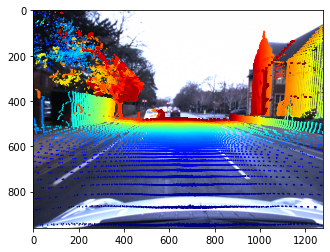

In [130]:
uv, depth = model.project(pointcloud, image.shape)

plt.imshow(image)
plt.scatter(np.ravel(uv[0, :]), np.ravel(uv[1, :]), s=2, c=depth, edgecolors='none', cmap='jet')
plt.xlim(0, image.shape[1])
plt.ylim(image.shape[0], 0)
plt.show()

In [96]:
# 0 < uv[0, :] < 1280
# 0 < uv[1, :] < 960
b = []
d = []
count = 0
for i in range(0, len(depth)):
    if 200 < uv[1, i] and uv[1, i] < 810 and depth[i] < 80:
        count += 1
        b.append([uv[0, i], uv[1, i]])
        d.append(depth[i])

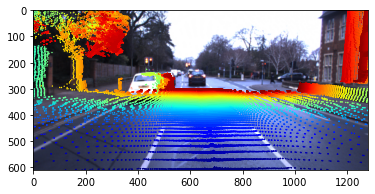

In [97]:
a = np.ndarray((2, count))

for i in range(0, count):
    a[0, i] = b[i][0]
    a[1, i] = b[i][1] - 200
    
img = image[200:810, :, :]
    
plt.imshow(img)
plt.scatter(np.ravel(a[0, :]), np.ravel(a[1, :]), s=2, c=d, edgecolors='none', cmap='jet')
plt.xlim(0, img.shape[1])
plt.ylim(img.shape[0], 0)
plt.show()

In [100]:
pred_disp = np.load(PREDICTIONS_DIR + '/' + '0000000000_disp.npy')
pred_disp = np.load(PREDICTIONS_DIR + '/' + '0000001260_disp.npy')
print(pred_disp.shape)
# (1, WIDTH, HEIGHT)
pred_disp = pred_disp[0]
# (WIDTH, HEIGHT)
pred_disp = pred_disp[0]
print(pred_disp.shape)

(1, 1, 416, 640)
(416, 640)


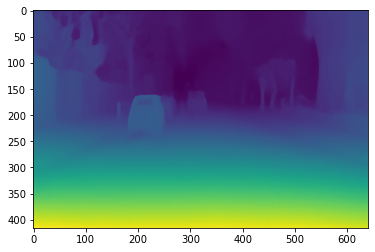

In [101]:
plt.imshow(pred_disp, interpolation='nearest')
plt.show()

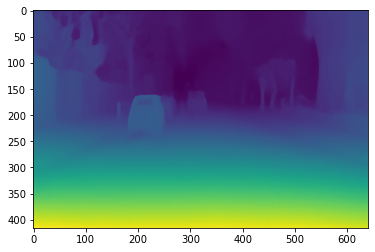

In [102]:

plt.imshow(pred_disp, interpolation='nearest')
plt.show()

(610, 1280)


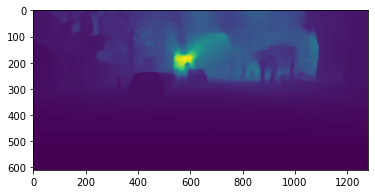

In [103]:
pred_disp = cv2.resize(pred_disp, (img.shape[1], img.shape[0]))
pred_depth = 1 / pred_disp
print(pred_depth.shape)
plt.imshow(pred_depth, interpolation='nearest')
plt.show()

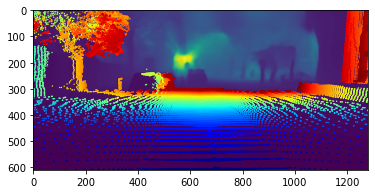

In [104]:
plt.imshow(pred_depth)
plt.scatter(np.ravel(a[0, :]), np.ravel(a[1, :]), s=2, c=d, edgecolors='none', cmap='jet')
plt.xlim(0, img.shape[1])
plt.ylim(img.shape[0], 0)
plt.show()

In [105]:
depth_mask = np.zeros((pred_depth.shape[0], pred_depth.shape[1]))
print(depth_mask.shape)

(610, 1280)


In [106]:
for i in range(0, a.shape[1]):
    if depth_mask[int(np.floor(a[1, i])), int(np.floor(a[0,i]))] == 0:
        depth_mask[int(np.floor(a[1, i])), int(np.floor(a[0,i]))] = depth[i]
        
    elif depth_mask[int(np.floor(a[1, i])), int(np.floor(a[0,i]))] > depth[i]:
        depth_mask[int(np.floor(a[1, i])), int(np.floor(a[0,i]))] = depth[i]

In [107]:
depth_mask.shape

(610, 1280)

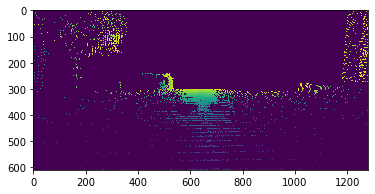

In [108]:
plt.imshow(depth_mask, interpolation='nearest')
plt.show()

In [109]:
MIN_DEPTH = 1
MAX_DEPTH = 80
dm = np.logical_and(depth_mask > MIN_DEPTH, depth_mask < MAX_DEPTH)

In [110]:
dtpm = depth_mask[dm]
prdpth = pred_depth[dm]

print(len(depth_mask[dm]))
print(len(pred_depth[dm]))

38940
38940


In [111]:
prdpth

array([ 0.6977914 ,  0.69448453,  0.6862861 , ...,  0.16189845,
        0.16193146,  0.16194619], dtype=float32)

In [112]:
ratio = np.median(dtpm) / np.median(prdpth)
ratio

24.066802242977733

In [113]:
prdpth *= ratio
prdpth

array([ 16.793608 ,  16.714022 ,  16.516712 , ...,   3.896378 ,
         3.8971725,   3.8975272], dtype=float32)

In [114]:
def compute_errors(gt, pred):
    """Computation of error metrics between predicted and ground truth depths
    """
    thresh = np.maximum((gt / pred), (pred / gt))

    a1 = (thresh < 1.25     ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt)

    sq_rel = np.mean(((gt - pred) ** 2) / gt)

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3

In [115]:
errors = []
errors.append(compute_errors(dtpm, prdpth))
mean_errors = np.array(errors).mean(0)
print("\n  " + ("{:>8} | " * 7).format("abs_rel", "sq_rel", "rmse", "rmse_log", "a1", "a2", "a3"))
print(("&{: 8.3f}  " * 7).format(*mean_errors.tolist()) + "\\\\")
print("\n-> Done!")


   abs_rel |   sq_rel |     rmse | rmse_log |       a1 |       a2 |       a3 | 
&   0.153  &   1.111  &   4.560  &   0.202  &   0.826  &   0.937  &   0.989  \\

-> Done!
